In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
def load_results(file_path: str):
    """Load results from pickle file."""
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def get_model_name(file_path):
    """Extract and format model name and configuration from filename."""
    name = Path(file_path).stem
    
    if 'dkl' in name.lower():
        # Parse DKL filename
        parts = name.split('_')
        latent_dim = next(p for p in parts if 'latent' in p)
        activation = next(p for p in parts if p in ['tanh', 'relu', 'silu'])
        return f"DKL (latent={latent_dim.replace('latent', '')}, {activation})"
    elif 'gp' in name.lower():
        # Parse GP filename
        parts = name.split('_')
        kernel = next(p for p in parts if 'kernel' in p)
        return f"GP ({kernel.replace('kernel', '')})"
    else:
        # Parse PBNN filename
        prob_part = name.split('_')[1]
        layers = prob_part.replace('prob', '').split('-')
        layer_names = []
        for l in layers:
            dense_num = l.replace('dense', '')
            #layer_names.append(f"Dense {dense_num}")
            layer_names.append(f"{dense_num}")
        return f"PBNN ({', '.join(layer_names)})"
    
def compute_statistics(results):
    """Compute mean and std for each metric across seeds."""
    metrics = {}
    
    # Handle both PBNN and DKL result formats
    if 'latent_dim' in results:  # DKL results
        runs_data = results['runs']
    else:  # PBNN results
        runs_data = results['runs']
    
    for metric in ['mse', 'nlpd', 'coverage']:
        values = np.array([runs_data[seed][metric] for seed in runs_data.keys()])
        mean = np.mean(values, axis=0)
        std = np.std(values, axis=0)
            
        metrics[metric] = {'mean': mean, 'std': std}
    
    return metrics

In [4]:
def plot_comparison(pbnn_files, dkl_files=None, gp_files=None, save_path=None):
    """Plots metrics comparing PBNN, DKL, and GP results."""
    plt.style.use('seaborn-v0_8-paper')
    
    pbnn_base_colors = [
        '#e31a1c',  # red
        '#6a3d9a',  # purple
        '#ff7f00',  # orange
        '#fb9a99'   # pink
    ]

    pbnn_colors = pbnn_base_colors #plt.cm.Reds(np.linspace(0.6, 0.9, len(pbnn_files)))
    if dkl_files:
        dkl_colors = plt.cm.Blues(np.linspace(0.6, 0.9, len(dkl_files)))
    if gp_files:
        gp_colors = plt.cm.Greys(np.linspace(0.6, 0.9, len(gp_files)))
    
    
    titles = {
        'mse': 'RMSE over Time',
        'nlpd': 'NLPD over Time (log scale)',
        'coverage': 'Coverage over Time'
    }
    
    ylabels = {
        'mse': 'Root Mean Square Error',
        'nlpd': 'Negative Log Predictive Density',
        'coverage': 'Coverage Probability'
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    final_values = {}
    
    # Plot PBNN results
    for file_path, color in zip(pbnn_files, pbnn_colors):
        results = load_results(file_path)
        metrics = compute_statistics(results)
        model_name = get_model_name(file_path)
        final_values[model_name] = {}
        
        for (metric, ax) in zip(metrics, axes):
            mean = metrics[metric]['mean']
            std = metrics[metric]['std']
            steps = np.arange(len(mean))
            
            if metric == 'mse':
                mean_rmse = np.sqrt(mean)
                std_rmse = std / (2 * np.sqrt(mean))
                plot_mean, plot_std = mean_rmse, std_rmse
            else:
                plot_mean, plot_std = mean, std
            
            line = ax.plot(steps, plot_mean, label=model_name, color=color, 
                         linewidth=3.5, alpha=0.8)[0]
            ax.fill_between(steps, plot_mean - plot_std, plot_mean + plot_std, 
                          color=line.get_color(), alpha=0.3)
            
            final_values[model_name][metric] = (plot_mean[-1], plot_std[-1])
    
    if dkl_files: # Plot DKL results
        for file_path, color in zip(dkl_files, dkl_colors):
            results = load_results(file_path)
            metrics = compute_statistics(results)
            model_name = get_model_name(file_path)
            final_values[model_name] = {}
            
            for (metric, ax) in zip(metrics, axes):
                mean = metrics[metric]['mean']
                std = metrics[metric]['std']
                steps = np.arange(len(mean))
                
                if metric == 'mse':
                    mean_rmse = np.sqrt(mean)
                    std_rmse = std / (2 * np.sqrt(mean))
                    plot_mean, plot_std = mean_rmse, std_rmse
                else:
                    plot_mean, plot_std = mean, std
                
                line = ax.plot(steps, plot_mean, label=model_name, color=color, 
                            linewidth=2.5, alpha=0.8, linestyle='--')[0]
                ax.fill_between(steps, plot_mean - plot_std, plot_mean + plot_std, 
                            color=line.get_color(), alpha=0.3)
                
                final_values[model_name][metric] = (plot_mean[-1], plot_std[-1])
    
    if gp_files: # Plot GP results
        for file_path, color in zip(gp_files, gp_colors):
            results = load_results(file_path)
            metrics = compute_statistics(results)
            model_name = get_model_name(file_path)
            final_values[model_name] = {}
            
            for (metric, ax) in zip(metrics, axes):
                mean = metrics[metric]['mean']
                std = metrics[metric]['std']
                steps = np.arange(len(mean))
                
                if metric == 'mse':
                    mean_rmse = np.sqrt(mean)
                    std_rmse = std / (2 * np.sqrt(mean))
                    plot_mean, plot_std = mean_rmse, std_rmse
                else:
                    plot_mean, plot_std = mean, std
                
                line = ax.plot(steps, plot_mean, label=model_name, color=color, 
                            linewidth=4.5, alpha=0.8, linestyle=':')[0]
                ax.fill_between(steps, plot_mean - plot_std, plot_mean + plot_std, 
                            color=line.get_color(), alpha=0.3)
                
                final_values[model_name][metric] = (plot_mean[-1], plot_std[-1])
        
    for metric, ax in zip(titles.keys(), axes):
        ax.set_title(titles[metric], fontsize=16, pad=10)
        ax.set_xlabel('Active Learning Steps', fontsize=16)
        ax.set_ylabel(ylabels[metric], fontsize=16)
        
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.tick_params(axis='both', which='major', labelsize=11)
        
        if metric == 'coverage':
            ax.set_ylim(0, 1)
            ax.set_yticks(np.arange(0, 1.1, 0.2))
        elif metric == 'nlpd':
            ax.set_yscale('log')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        legend = ax.legend(loc='best', frameon=True, framealpha=0.9, 
                         fontsize=12, title='Models')
        legend.get_title().set_fontsize(14)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('none')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # Print final values
    print("\nFinal values (mean ± std):")
    for model_name in final_values:
        print(f"\n{model_name}:")
        for metric in ['mse', 'nlpd', 'coverage']:
            mean, std = final_values[model_name][metric]
            if metric == 'mse':
                print(f"  RMSE: {mean:.4f} ± {std:.4f}") 
            else:
                print(f"  {metric.upper()}: {mean:.4f} ± {std:.4f}")


def plot_final_results(pbnn_files, dkl_files, gp_files, save_path=None):
    """Creates bar plots of final metric values for all models."""
    plt.style.use('seaborn-v0_8-paper')
    
    # Load and process results
    final_values = {}
    
    # Process PBNN results
    for file_path in pbnn_files:
        results = load_results(file_path)
        metrics = compute_statistics(results)
        model_name = get_model_name(file_path)
        final_values[model_name] = {
            metric: (metrics[metric]['mean'][-1], metrics[metric]['std'][-1])
            for metric in ['mse', 'nlpd', 'coverage']
        }
    
    # Process DKL results
    for file_path in dkl_files:
        results = load_results(file_path)
        metrics = compute_statistics(results)
        model_name = get_model_name(file_path)
        final_values[model_name] = {
            metric: (metrics[metric]['mean'][-1], metrics[metric]['std'][-1])
            for metric in ['mse', 'nlpd', 'coverage']
        }
    
    # Process GP results
    for file_path in gp_files:
        results = load_results(file_path)
        metrics = compute_statistics(results)
        model_name = get_model_name(file_path)
        final_values[model_name] = {
            metric: (metrics[metric]['mean'][-1], metrics[metric]['std'][-1])
            for metric in ['mse', 'nlpd', 'coverage']
        }
    
    # Prepare data for plotting
    models = list(final_values.keys())
    metrics = ['mse', 'nlpd', 'coverage']
    titles = {
        'mse': 'Final RMSE',
        'nlpd': 'Final NLPD',
        'coverage': 'Final Coverage'
    }
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Set bar positions
    x = np.arange(len(models))
    bar_width = 0.8
    
    for metric, ax in zip(metrics, axes):
        # Extract values and errors for current metric
        values = [final_values[model][metric][0] for model in models]
        errors = [final_values[model][metric][1] for model in models]
        
        # Take square root for MSE values to show RMSE
        if metric == 'mse':
            values = [np.sqrt(v) for v in values]
            errors = [e / (2 * np.sqrt(v)) for e, v in zip(errors, values)]  # error propagation
        
        # Create bars
        bars = ax.bar(x, values, bar_width, 
                     yerr=errors, 
                     capsize=5,
                     error_kw={'capthick': 2})
        
        # Color bars based on model type
        for i, bar in enumerate(bars):
            if 'PBNN' in models[i]:
                bar.set_color(plt.cm.Reds(0.6))
            elif 'DKL' in models[i]:
                bar.set_color(plt.cm.Blues(0.6))
            else:  # GP
                bar.set_color(plt.cm.Greys(0.6))
        
        # Customize plot
        ax.set_title(titles[metric], fontsize=16, pad=10)
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha='right')
        
        if metric == 'coverage':
            ax.set_ylim(0, 1)
        # elif metric == 'nlpd':
        #     ax.set_yscale('log')
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add grid
        ax.grid(True, alpha=0.3, linestyle='--', axis='y')
        
        # Adjust tick label size
        ax.tick_params(axis='both', which='major', labelsize=11)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, axes

## PBNN-8-8-8-8

### SILU


Final values (mean ± std):

PBNN (0, 4):
  RMSE: 0.6879 ± 0.0163
  NLPD: 1.0647 ± 0.0232
  COVERAGE: 0.9659 ± 0.0076

PBNN (1, 4):
  RMSE: 0.7391 ± 0.0262
  NLPD: 1.1312 ± 0.0439
  COVERAGE: 0.9187 ± 0.0087

PBNN (2, 4):
  RMSE: 0.7441 ± 0.0141
  NLPD: 1.2116 ± 0.0470
  COVERAGE: 0.8758 ± 0.0145

PBNN (3, 4):
  RMSE: 0.8138 ± 0.0236
  NLPD: 1.3482 ± 0.0258
  COVERAGE: 0.8641 ± 0.0115


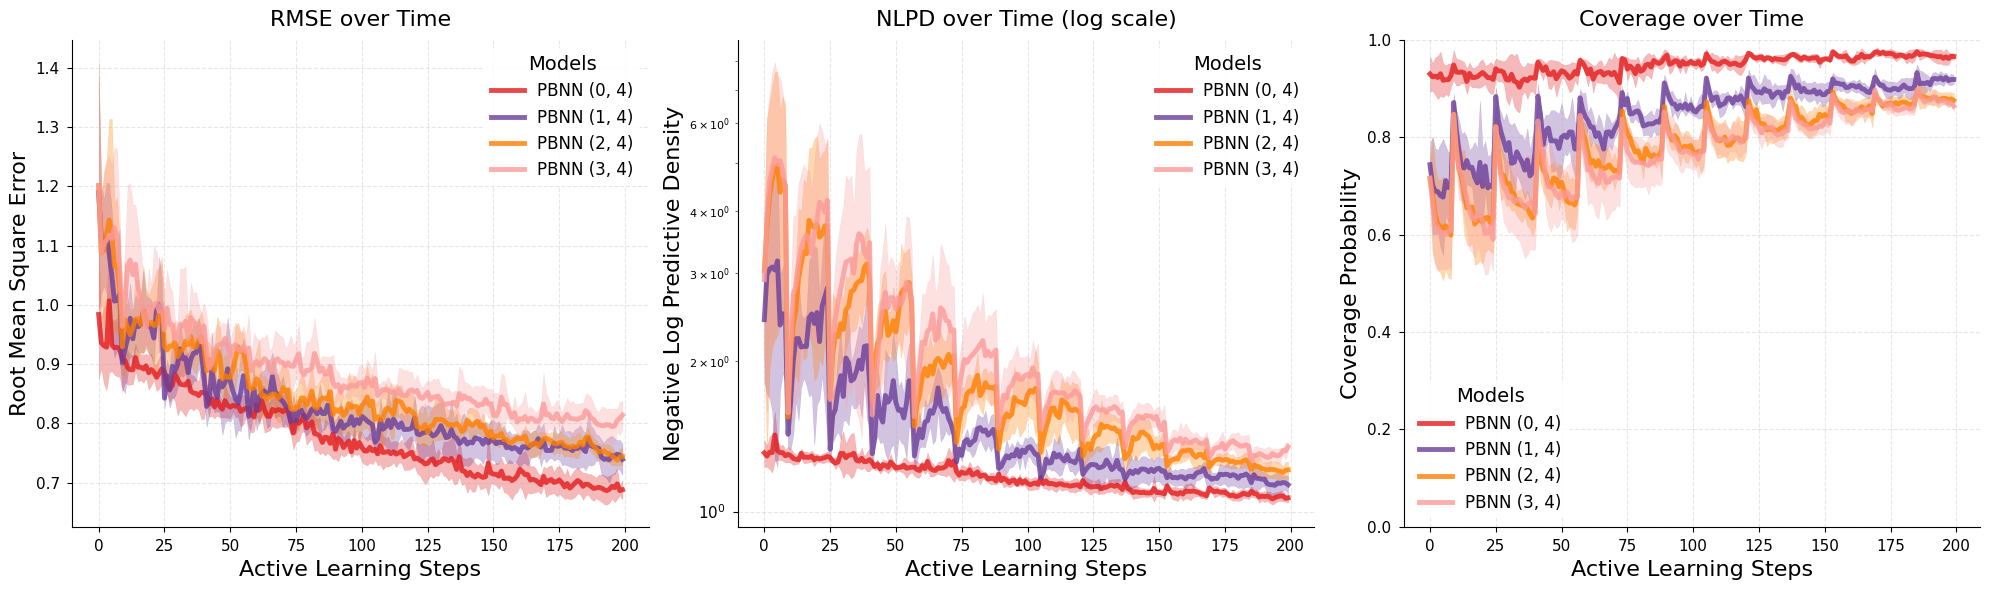

In [17]:
pbnn_files = [
    'results/pbnn8888/esol_probdense0-dense4_steps200_epochs2000_lr0.005_20241207_015431.pkl',
    'results/pbnn8888/esol_probdense1-dense4_steps200_epochs2000_lr0.005_20241207_052815.pkl',
    'results/pbnn8888/esol_probdense2-dense4_steps200_epochs2000_lr0.005_20241207_080057.pkl',
    'results/pbnn8888/esol_probdense3-dense4_steps200_epochs2000_lr0.005_20241206_220527.pkl'
]

plot_comparison(
    pbnn_files=pbnn_files,
    save_path='comparison_plot-pbnn8888-silu.png'
);

Compare with GP:


Final values (mean ± std):

PBNN (0, 4):
  RMSE: 0.6879 ± 0.0163
  NLPD: 1.0647 ± 0.0232
  COVERAGE: 0.9659 ± 0.0076

DKL (latent=2, silu):
  RMSE: 0.7986 ± 0.0240
  NLPD: 1.2017 ± 0.0232
  COVERAGE: 0.9597 ± 0.0084


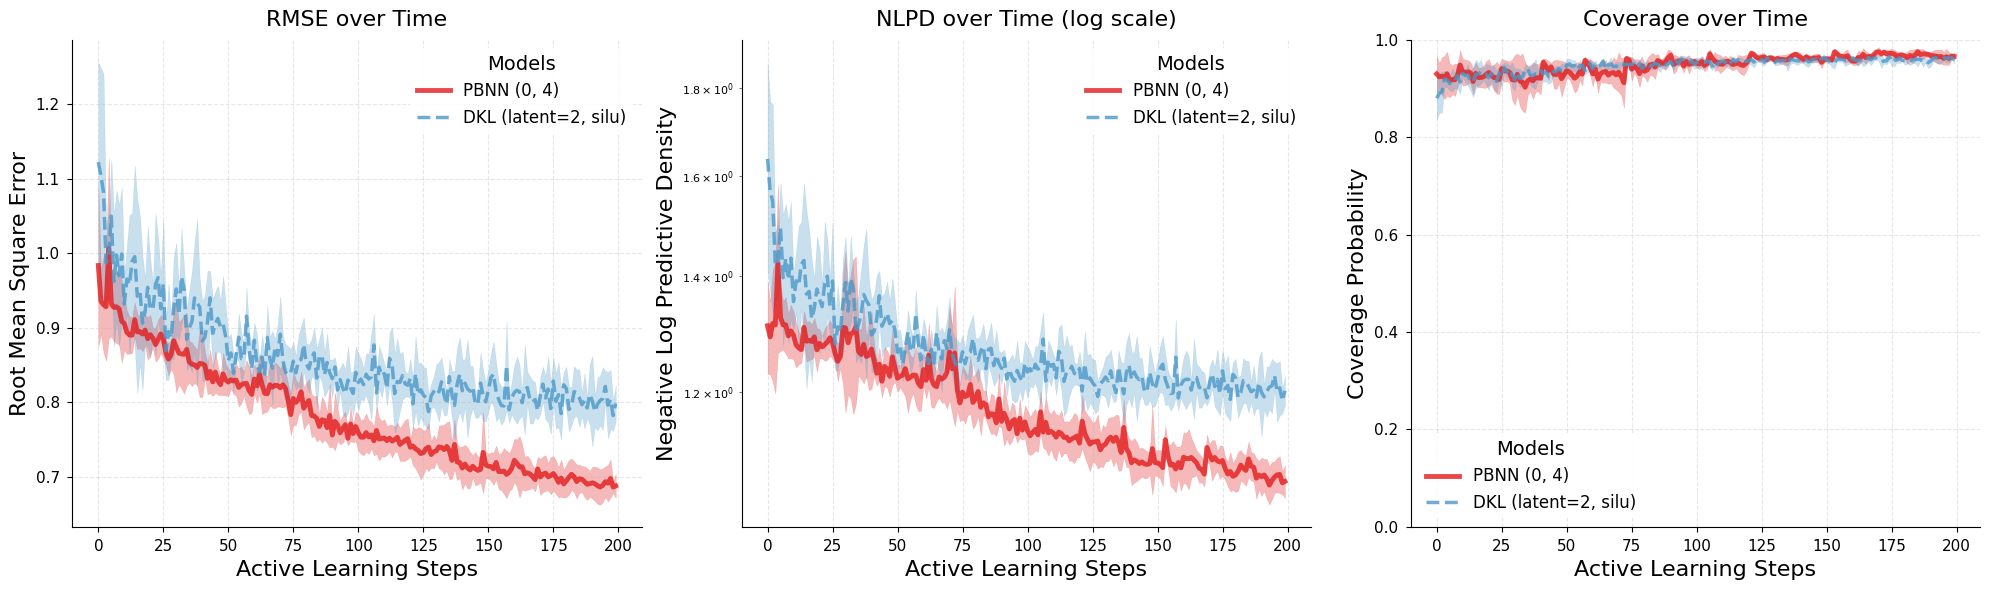

In [22]:
pbnn_files = [
    'results/pbnn8888/esol_probdense0-dense4_steps200_epochs2000_lr0.005_20241207_015431.pkl'
]

dkl_files = [
    'results/dkl8888/esol_dkl_latent2_silu_20241207_132112.pkl'
]

plot_comparison(
    pbnn_files=pbnn_files,
    dkl_files=dkl_files,
    save_path='comparison_plot-dkl-pbnn8888-silu.png'
);

## Tanh

TBA

## PBNN-32-16-8-8

### SILU

Compare results with a single middle hiddle layer (16 neurons) and two last hidden layers (8+8 neurons):


Final values (mean ± std):

PBNN (1, 4):
  RMSE: 0.7097 ± 0.0130
  NLPD: 1.0905 ± 0.0308
  COVERAGE: 0.9194 ± 0.0160

PBNN (2, 3, 4):
  RMSE: 0.7558 ± 0.0217
  NLPD: 1.2595 ± 0.0947
  COVERAGE: 0.8676 ± 0.0287


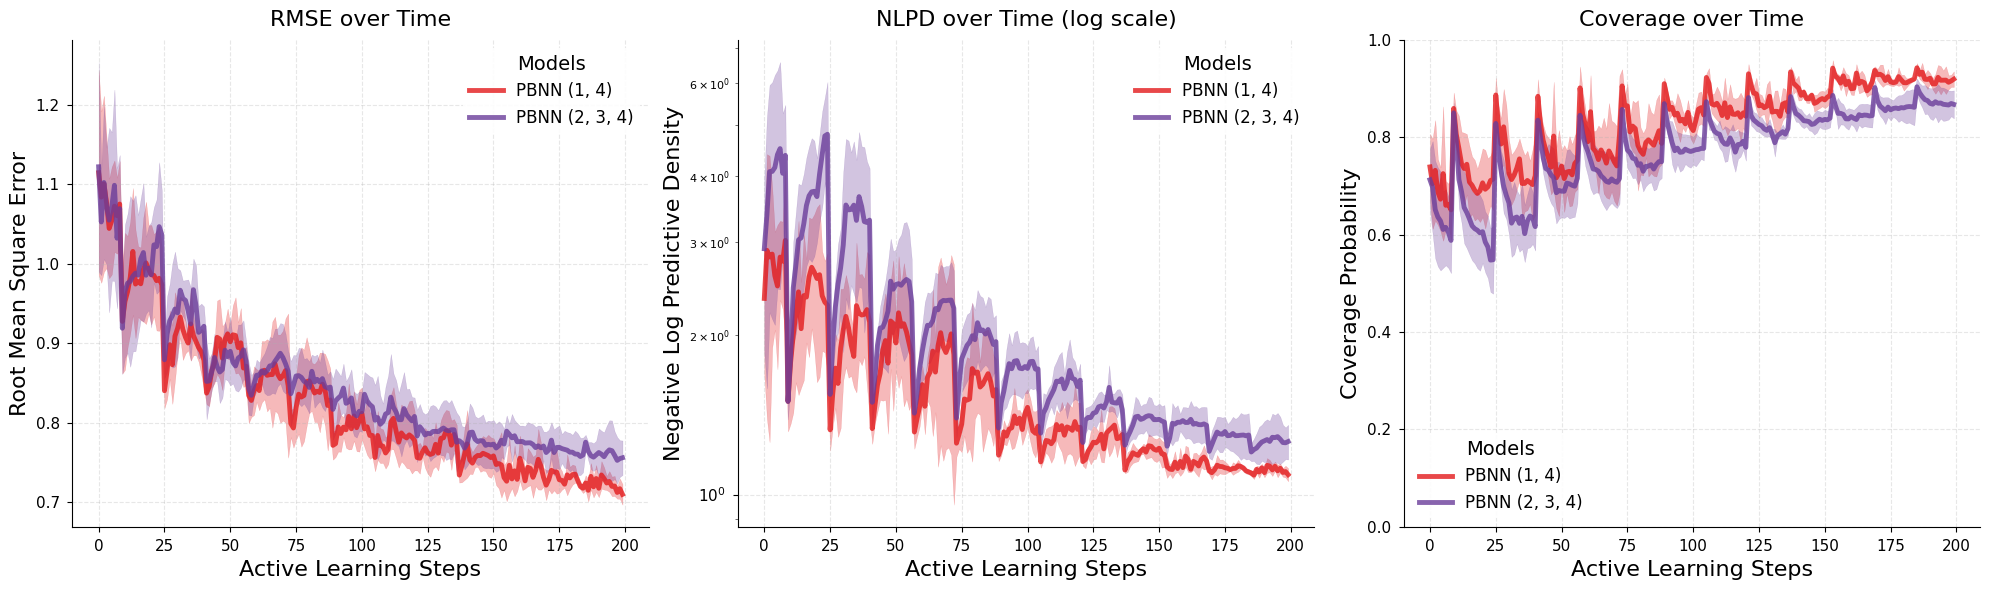

In [13]:
pbnn_files = [
    'results/pbnn321688/esol_probdense1-dense4_steps200_epochs2000_lr0.005_20241202_064817.pkl',
    'results/pbnn321688/esol_probdense2-dense3-dense4_steps200_epochs2000_lr0.005_20241202_132548.pkl'
]


plot_comparison(
    pbnn_files=pbnn_files,
    save_path='comparison_plot-pbnn321688-16neurons-silu.png'
);

Comparison with DKL:


Final values (mean ± std):

PBNN (1, 4):
  RMSE: 0.7097 ± 0.0130
  NLPD: 1.0905 ± 0.0308
  COVERAGE: 0.9194 ± 0.0160

DKL (latent=2, silu):
  RMSE: 0.7717 ± 0.0237
  NLPD: 1.1657 ± 0.0257
  COVERAGE: 0.9553 ± 0.0085


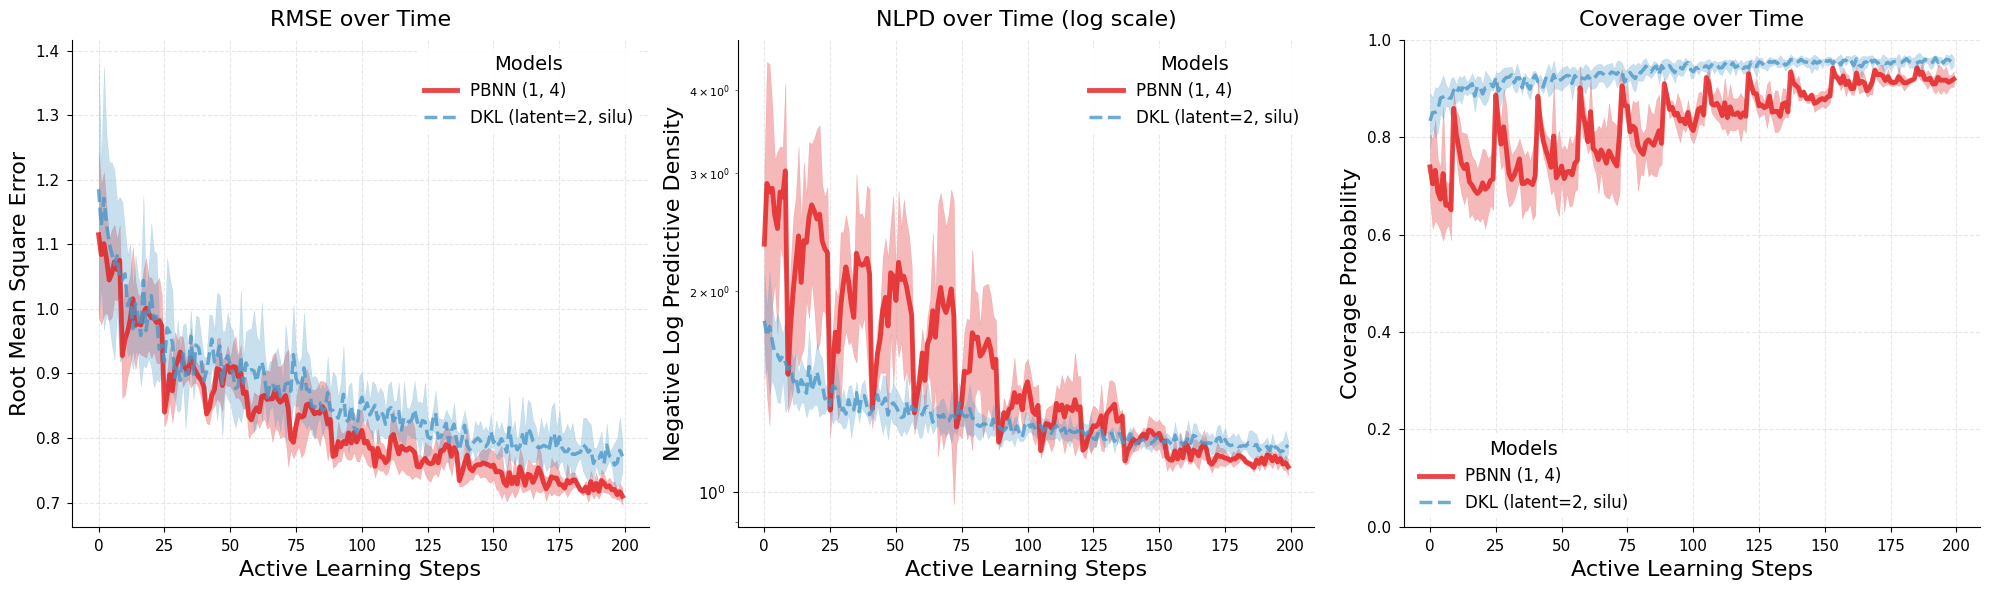

In [24]:
pbnn_files = [
    'results/pbnn321688/esol_probdense1-dense4_steps200_epochs2000_lr0.005_20241202_064817.pkl',
]

dkl_files = [
    'results/dkl321688/esol_dkl_comparison_latent2_silu_20241206_013705.pkl'
]

plot_comparison(
    pbnn_files=pbnn_files,
    dkl_files=dkl_files,
    save_path='comparison_plot-dkl-pbnn321688-silu.png'
);

### Tanh

Compare results with a single middle hiddle layer (16 neurons) and two last hidden layers (8+8 neurons):


Final values (mean ± std):

PBNN (2, 3, 4):
  RMSE: 0.7535 ± 0.0172
  NLPD: 1.2681 ± 0.0602
  COVERAGE: 0.8687 ± 0.0216

PBNN (1, 4):
  RMSE: 0.7504 ± 0.0287
  NLPD: 1.1784 ± 0.0785
  COVERAGE: 0.8985 ± 0.0274


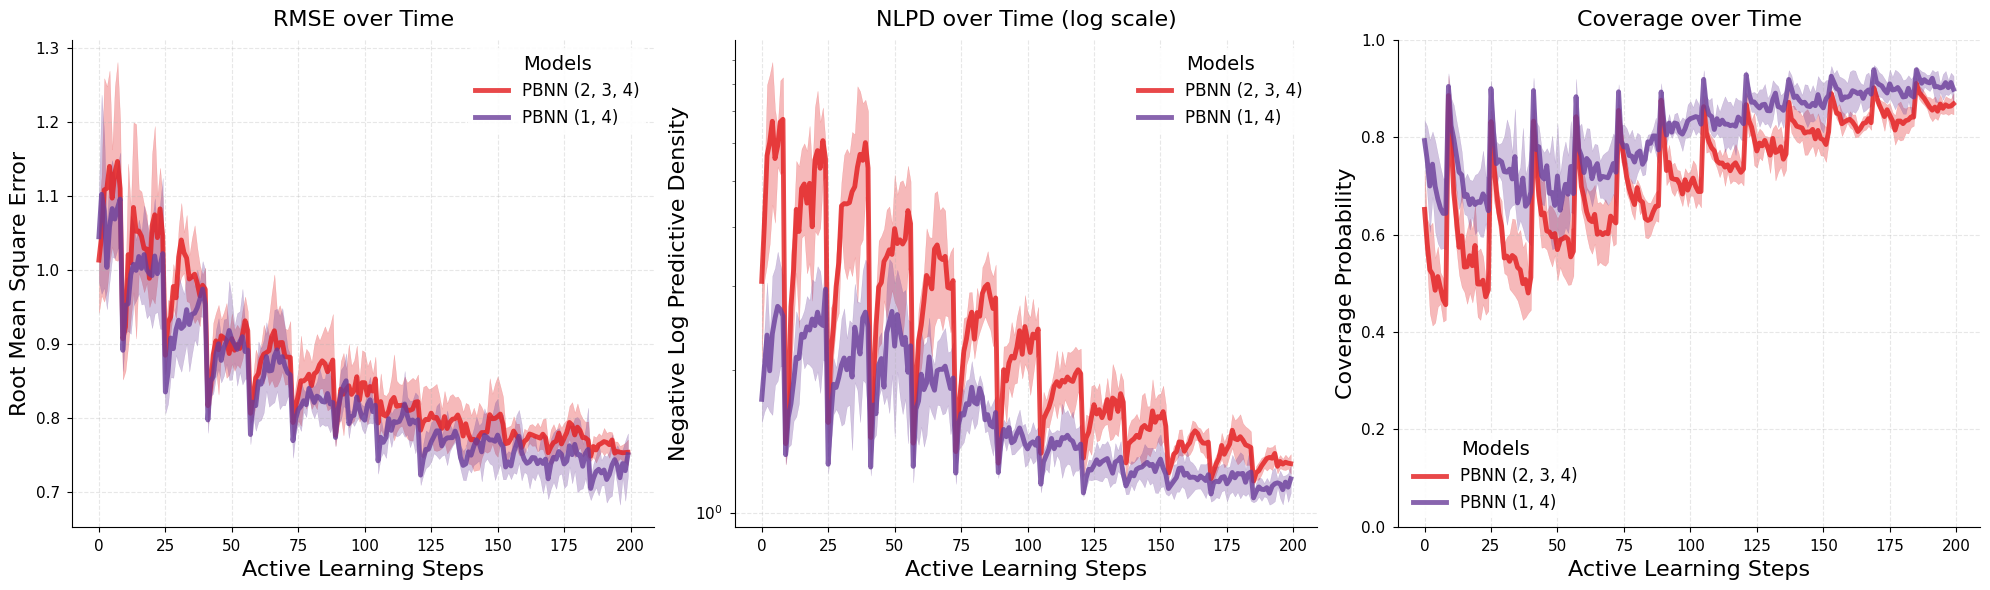

In [ ]:
pbnn_files = [
    'results/pbnn321688/esol_probdense1-dense4_steps200_epochs2000_lr0.005_20241201_193626.pkl',
    'results/pbnn321688/esol_probdense2-dense3-dense4_steps200_epochs2000_lr0.005_20241201_073300.pkl'
]

# Create both visualizations
plot_comparison(
    pbnn_files=pbnn_files,
    save_path='comparison_plot-pbnn321688-16neurons-tanh.png'
);

Comparison with DKL:


Final values (mean ± std):

PBNN (1, 4):
  RMSE: 0.7504 ± 0.0287
  NLPD: 1.1784 ± 0.0785
  COVERAGE: 0.8985 ± 0.0274

DKL (latent=2, tanh):
  RMSE: 0.8199 ± 0.0452
  NLPD: 1.2210 ± 0.0555
  COVERAGE: 0.9356 ± 0.0149


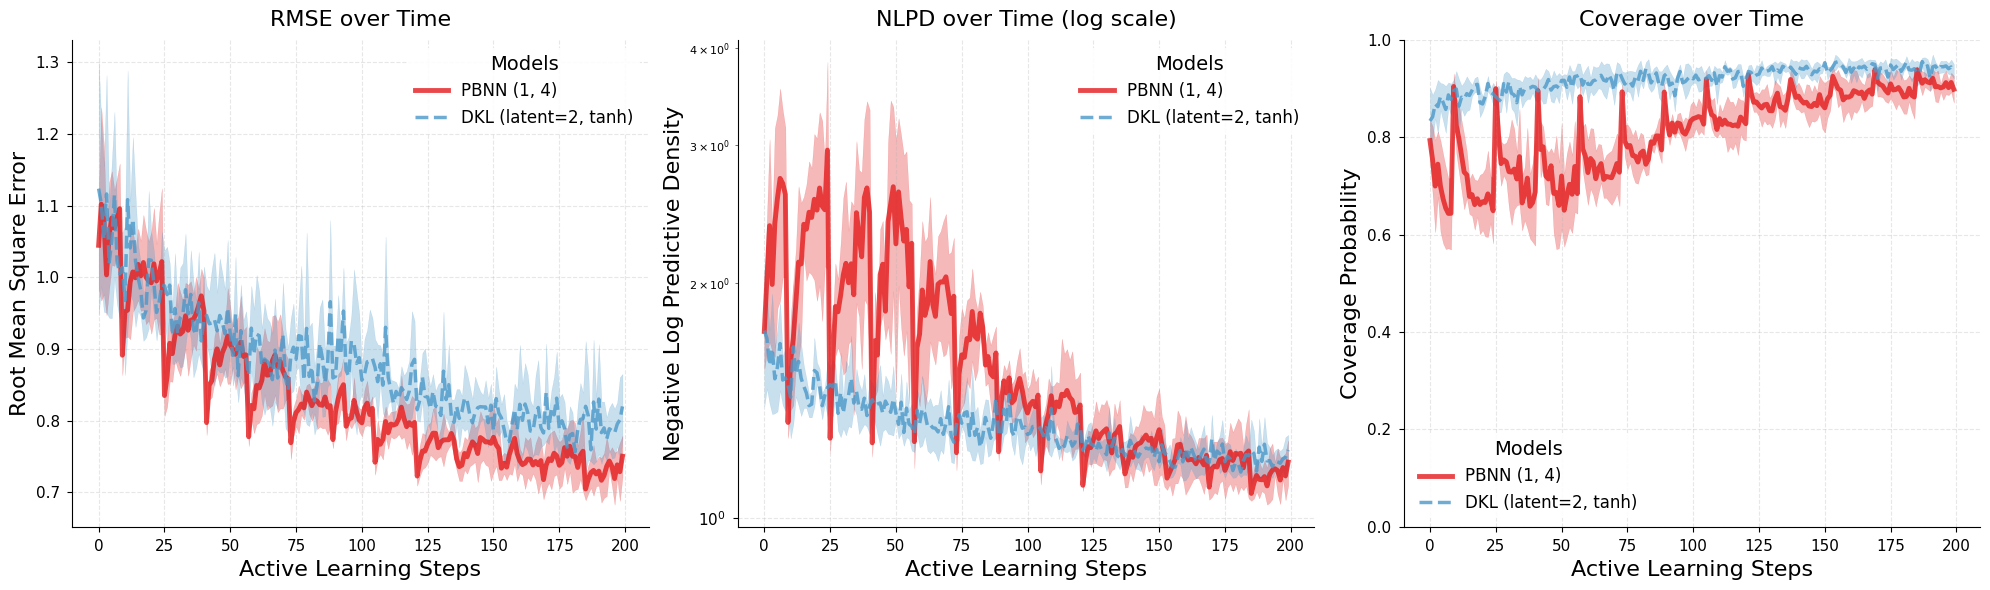

In [25]:
pbnn_files = [
    'results/pbnn321688/esol_probdense1-dense4_steps200_epochs2000_lr0.005_20241201_193626.pkl',
]

dkl_files = [
    'results/dkl321688/esol_dkl_comparison_latent2_tanh_20241206_013348.pkl'
]

plot_comparison(
    pbnn_files=pbnn_files,
    dkl_files=dkl_files,
    save_path='comparison_plot-dkl-pbnn321688-tanh.png'
);